# ML model for CsPb(Cl/Br)3 structure optimization
In this demonstration of the many-body tensor representation (MBTR) derivatives, we fit an energy prediction machine learning (ML) model on a data set of CsPb(Cl/Br)3 perovskite structures generated for an earlier [study](https://doi.org/10.1103/PhysRevMaterials.6.113801). We utilize the fitted ML model in force prediction and structure optimization.

## Data
We start by downloading the data from a [Zenodo repository](https://doi.org/10.5281/zenodo.7153019):

In [1]:
!python -m zenodo_get 10.5281/zenodo.7153019

Title: CsPb(Cl/Br)3 DFT Dataset
Keywords: Perovskites, Density functional theory
Publication date: 2022-10-06
DOI: 10.5281/zenodo.7153019
Total size: 13.0 MB

Link: https://zenodo.org/api/files/ae2e3d51-b2bd-403b-af8d-a982d7d99e0d/cspbclbr.zip   size: 13.0 MB
100% [....................................................] 13629003 / 13629003
Checksum is correct. (7b85571fc62650a5558df2f56b4b32d1)
All files have been downloaded.


Then we extract the data:

In [2]:
import zipfile

with zipfile.ZipFile("cspbclbr.zip", 'r') as f:
    f.extractall("data")

`data/cspbclbr` folder now contains four data sets of 40 atom CsPb(Cl/Br)3 atomic structures and their DFT total energies. We use three of these data sets:

| Data set name | Information |
| :------------ | :---------- |
| **cspbclbr\_single\_point** | Algorithmically generated CsPb(Cl/Br)3 structures of four different phases: Pm-3m, P4/mbm, I4/mcm, and Pnma. The Cl concentration follows binomial distribution. |
| **cspbclbr\_single\_point\_tails** | Extends on **cspbclbr\_single\_point** by adding structures at the ends of the Cl concentration range. |
| **cspbclbr\_relax\_uniform** | Structure snapshots from 200 DFT relaxations. Covers equally phases Pm3m, P4/mbm, I4/mcm, and Pnma. The Cl concentration range is covered uniformly. Has atomic forces for each structure. |

The data sets are loaded with the following functions:

In [3]:
import numpy as np
import pandas as pd
import itertools
import ase.io


def load_cspbclbr_single_point():
    """
    Loads a data set of CsPb(Cl/Br)3 atomic structures and their properties:
        "total_energy": DFT total energy
        "lattice_type": lattice type of the structure (pm3m, p4mbm, i4mcm, or pnma)
    Returns:
        Pandas DataFrame: data frame containing the structures and the
        properties
    """
    dir_path = "data/cspbclbr/cspbclbr_single_point/"

    phases = ["i4mcm", "p4mbm", "pm3m", "pnma"]

    properties = {}
    properties["structure"] = []
    properties["total_energy"] = []
    properties["lattice_type"] = []

    for phase in phases:
        s = ase.io.read("{0}/{1}/structures.xyz".format(dir_path, phase), index=":")
        properties["structure"] += s
        properties["total_energy"] += list(
            np.loadtxt("{0}/{1}/etot.dat".format(dir_path, phase))
        )
        properties["lattice_type"] += len(s) * [phase]

    return pd.DataFrame(data=properties)


def load_cspbclbr_single_point_tails():
    """
    Loads a data set of CsPb(Cl/Br)3 atomic structures and their properties:
        "total_energy": DFT total energy
        "lattice_type": lattice type of the structure (pm3m, p4mbm, i4mcm, or pnma)
    Returns:
        Pandas DataFrame: data frame containing the structures and the
        properties
    """
    dir_path = "data/cspbclbr/cspbclbr_single_point_tails/"

    phases = ["i4mcm", "p4mbm", "pm3m", "pnma"]

    properties = {}
    properties["structure"] = []
    properties["total_energy"] = []
    properties["lattice_type"] = []

    for phase in phases:
        s = ase.io.read("{0}/{1}/structures.xyz".format(dir_path, phase), index=":")
        properties["structure"] += s
        properties["total_energy"] += list(
            np.loadtxt("{0}/{1}/etot.dat".format(dir_path, phase))
        )
        properties["lattice_type"] += len(s) * [phase]

    return pd.DataFrame(data=properties)


def load_cspbclbr_relax_uniform():
    """
    Loads a data set of CsPb(Cl/Br)3 atomic structures and their properties:
        "relaxation_number": number of the DFT relaxation matching the file name in the data set
        "relaxation_iteration": iteration number within the DFT relaxation
        "relaxed": tag indicating whether a structure is fully relaxed (True) or not (False)
        "total_energy": DFT total energy
        "lattice_type": lattice type of the structure (pm3m, p4mbm, i4mcm, or pnma)
    Returns:
        Pandas DataFrame: data frame containing the structures and the
        properties
    """
    dir_path = "data/cspbclbr/cspbclbr_relax_uniform/"

    properties = {}
    properties["structure"] = []
    properties["relaxation_number"] = []
    properties["relaxation_iteration"] = []
    properties["relaxed"] = []
    properties["total_energy"] = []
    properties["lattice_type"] = []

    for phase in ["i4mcm", "p4mbm", "pm3m", "pnma"]:
        for i in range(3001, 3051):
            path = "{}/{}/{}0{}".format(dir_path, phase, phase, i)
            s = ase.io.read(path + ".xyz", index=":")
            properties["structure"] += s
            properties["relaxation_number"] += len(s) * [i]
            properties["relaxation_iteration"] += list(range(len(s)))
            properties["total_energy"] += list(
                np.loadtxt(path + "_etot.dat".format(dir_path, phase))
            )
            properties["lattice_type"] += len(s) * [phase]
            properties["relaxed"] += (len(s) - 1) * [False] + [True]

    return pd.DataFrame(data=properties)

These data sets are combined to create new data sets:

| Data set name | Information |
| :------------ | :---------- |
| **merged\_uniform\_single\_point** | Combination of **cspbclbr\_single\_point** and **cspbclbr\_single\_point\_tails**. 10 000 structures picked randomly from the two sets so that the Cl concentration follows uniform distribution over the whole range [0,1].|
| **merged\_uniform** | Union of **merged\_uniform\_single\_point** and **cspbclbr\_relax\_uniform**.|

**merged\_uniform** is the data set the we will use to fit and test the ML model. On top of merging the data, we add a label to the data that determines which data points will be used for model training. Here we include all 10 000 single point structures (**merged_uniform_single_point** data set) and half of the DFT relaxation trajectories to the training set.

The merged data sets are loaded with the following functions:

In [4]:
def merged_uniform_single_point_data():
    """
    Merges the single point data sets. Drops out some structures randomly so
    that the resulting data set is uniform with regard to the Cl concentration.
    Returns:
        Pandas DataFrame: data frame containing the structures and the
        properties
    """

    pick_rng = np.random.RandomState(0)
    shuffle_rng = np.random.RandomState(1)

    d_binomial = load_cspbclbr_single_point()
    d_tails = load_cspbclbr_single_point_tails()

    d_all = pd.concat([d_binomial, d_tails], ignore_index=True)

    n_cl = np.array(
        [np.sum(st.get_atomic_numbers() == 17) for st in d_all["structure"]]
    )
    i_all = np.arange(len(n_cl))

    d_merge = {}
    i_merge = []
    for phase in ["i4mcm", "p4mbm", "pm3m", "pnma"]:
        i_merge_phase = []
        for N_cl in range(25):
            mask = np.logical_and(d_all["lattice_type"] == phase, n_cl == N_cl)
            random_selection = pick_rng.choice(np.sum(mask), 100, replace=False)
            indices = i_all[mask][random_selection]
            i_merge_phase += list(indices)

        shuffle_rng.shuffle(i_merge_phase)
        i_merge += i_merge_phase

    d_merge = d_all.take(i_merge)
    d_merge.reset_index(drop=True, inplace=True)

    return d_merge


def merged_uniform_data():
    """
    Costructs a data set that has single point structures and relaxations.
    Splits the set into training and test sets and saves the information in the
    returned data frame with key 'train' (True or False).
    Returns:
        Pandas DataFrame: data frame containing the structures and the
        properties
    """

    d_s = merged_uniform_single_point_data()
    d_r = load_cspbclbr_relax_uniform()

    d = pd.concat([d_s, d_r], ignore_index=True)

    d["train"] = len(d_s) * [True] + list(d_r["relaxation_number"] % 2 == 1)

    return d

## ML model
We use MBTR descriptor from [DScribe](https://singroup.github.io/dscribe/latest/) to represent the atomic structures in vector form. The MBTR vectors are mapped to energy values with kernel ridge regression (KRR) from [scikit-learn](https://scikit-learn.org/). In order to make this mapping easier to learn, we transform the total DFT energies to normalized enthalpy of mixing values.

`Model` class encapsulates these three components (MBTR, KRR, and energy tranformation) for ease of use.

### Model setup
First we define the normalized enthalpy of mixing transformation for CsPb(Cl/Br)3:

In [5]:
# DFT energies for relaxed pure pnma structures
_dft_energies = {
    "cspbbr3_pnma": -8154836.843918324,
    "cspbcl3_pnma": -6743759.909496200,
}


class EnthalpyOfMixingTransformation:
    
    def transform(self, e_tot, structures):
        e0 = _dft_energies["cspbbr3_pnma"]
        e24 = _dft_energies["cspbcl3_pnma"]

        n_cl = np.array([np.sum(s.get_atomic_numbers() == 17) for s in structures])
        e_trans = e_tot - (e24 - e0) / 24 * n_cl - e0
        return e_trans

    def inv_transform(self, e_trans, structures):
        e0 = _dft_energies["cspbbr3_pnma"]
        e24 = _dft_energies["cspbcl3_pnma"]

        n_cl = np.array([np.sum(s.get_atomic_numbers() == 17) for s in structures])
        e_tot = e_trans + (e24 - e0) / 24 * n_cl + e0
        return e_tot

    def scale(self):
        return 1


class PreprocessingTransformation:
    """
    Energy transformation that combines the enthalpy of mixing transformation
    with translating and scaling the data so that the mean is 0 and the
    standard deviation is 1.
    """

    def __init__(self, e_tot, structures):
        e_nonlinear = EnthalpyOfMixingTransformation().transform(e_tot, structures)
        mean = np.mean(e_nonlinear)
        std = np.std(e_nonlinear)

        self._shift = -mean
        self._scale = 1 / std

    def transform(self, e_tot, structures):
        e_nonlinear = EnthalpyOfMixingTransformation().transform(e_tot, structures)
        e_trans = (e_nonlinear + self._shift) * self._scale
        return e_trans

    def inv_transform(self, e_trans, structures):
        e_scaled_and_shifted = e_trans / self._scale - self._shift
        e_tot = EnthalpyOfMixingTransformation().inv_transform(
            e_scaled_and_shifted, structures
        )
        return e_tot

    def scale(self):
        return self._scale

Next, we set up the MBTR representation:

In [6]:
from dscribe.descriptors import MBTR

mbtr = MBTR(
    species=["Cs", "Pb", "Cl", "Br"],
    geometry={"function": "inverse_distance"},
    grid={
        "min": -0.1,
        "max": 0.6,
        "sigma": 0.017519115236635203,
        "n": 50
    },
    weighting={
        "function": "exp",
        "r_cut": 5.7 * 1.1,  # 1.1 times mean lattice vector length
        "threshold": 1e-3,
    },
    periodic=True,
    normalization="none",
)

To predict energy derivatives, we need to differentiate KRR. Here we define a class that inherits from KRR class of scikit-learn and adds function `predict_derivatives` for predicting derivatives.

In [7]:
from sklearn.kernel_ridge import *

class KRR_d(KernelRidge):
    def predict_derivatives(self, X, X_d):
        check_is_fitted(self)

        K = self._get_kernel(X, self.X_fit_)
        K_d = np.empty((X_d.shape[1], K.shape[0], K.shape[1]))
        for k in range(len(X)):
            for j in range(len(self.X_fit_)):
                K_d[:, k, j] = -2 * K[k, j] * self.gamma * np.dot(X_d[k, :], X[k] - self.X_fit_[j])
                
        return np.dot(K_d, self.dual_coef_).T

Finally, we set up the `Model`-class that combines the energy transformation, MBTR and KRR:

In [8]:
class Model:
    def __init__(self, mbtr, krr, transformation):
        self.mbtr = mbtr
        self.krr = krr
        self.transformation = transformation

    def fit_X(self, X, y, structures):
        y_trans = self.transformation.transform(y, structures)
        self.krr.fit(X, y_trans)

    def fit(self, structures, y, n_jobs=4):
        X = self.mbtr.create(structures, n_jobs=n_jobs)
        self.fit_X(X, y, structures)
        return X

    def predict_from_X(self, X, structures):
        y_trans = self.krr.predict(X)
        y = self.transformation.inv_transform(y_trans, structures)
        return y

    def predict_derivatives_from_X(self, X, X_d):
        y_trans_d = self.krr.predict_derivatives(X, X_d)
        y_d = y_trans_d / self.transformation.scale()
        return y_d

    def predict_from_structure(self, structures, properties=["y"], n_jobs=4):
        for p in properties:
            if p not in ["y", "atomic_derivatives"]:
                raise ValueError(f"'{p}' is not a supported property.")

        n_atoms = len(structures[0].get_atomic_numbers())

        ret = {}
        if "y" in properties:
            ret["y"] = np.zeros(len(structures))
        if "atomic_derivatives" in properties:
            ret["atomic_derivatives"] = np.zeros((len(structures), n_atoms, 3))

        if "atomic_derivatives" not in properties:
            X = self.mbtr.create(structures, n_jobs=n_jobs)
            if "y" in ret:
                ret["y"] = self.predict_from_X(X, structures)
        else:
            # Iterating over the structures n_jobs at a time in order to use less memory
            for start in range(0, len(structures), n_jobs):
                end = min(start + n_jobs, len(structures))
                s_part = [structures[i] for i in range(start, end)]

                X_d, X = mbtr.derivatives(s_part, n_jobs=n_jobs)

                # Reshaping
                X = X.reshape(len(s_part), -1)
                X_d = X_d.reshape((len(s_part), -1, X.shape[1]))

                d = self.predict_derivatives_from_X(X, X_d)

                if "y" in ret:
                    ret["y"][start:end] = self.predict_from_X(X, s_part)
                if "atomic_derivatives" in ret:
                    ret["atomic_derivatives"][start:end] = d[:, : n_atoms * 3].reshape(-1, n_atoms, 3)

        return ret[properties[0]] if len(properties) == 1 else ret

### Fitting and saving the model
We fit the ML model to the training portion of the data and save the model binary to file `model.bin`.

In [9]:
import pickle

d = merged_uniform_data()

transformation = PreprocessingTransformation(d["total_energy"], d["structure"])
krr = KRR_d(kernel="rbf", alpha=1e-5, gamma=0.00012801248464134623)
model = Model(mbtr, krr, transformation)

# Fitting
s_tr = d.loc[d["train"], "structure"]
et_tr = d.loc[d["train"], "total_energy"]
model.fit(s_tr, et_tr)

# Saving
pickle.dump(model, open("model.bin", "wb"))

## ML model testing
We test the fitted model by predicting energies and atomic forces of the test set structures.

In [11]:
# Predict test set energies

import pickle
import os

model = pickle.load(open("model.bin", "rb"))
d = merged_uniform_data()

te_mask = d["train"] == False
s_te = d.loc[te_mask, "structure"].values
e_te = d.loc[te_mask, "total_energy"].values

e_te = np.array(e_te)
e_pr = model.predict_from_structure(s_te, n_jobs=4)

# Saving the enthalpy of mixing per atom in meV
e_te = 1000 / 40 * EnthalpyOfMixingTransformation().transform(e_te, s_te)
e_pr = 1000 / 40 * EnthalpyOfMixingTransformation().transform(e_pr, s_te)

# Saving the predictions and reference values so that
# tests don't need to be rerun for plotting.
if not os.path.exists("predictions"):
    os.makedirs("predictions")
np.save("predictions/e_ml", e_pr)
np.save("predictions/e_dft", e_te)

In [12]:
# Predict test set forces

import pickle
import os

model = pickle.load(open("model.bin", "rb"))
d = merged_uniform_data()

te_mask = d["train"] == False
s_te = d.loc[te_mask, "structure"].values
e_te = d.loc[te_mask, "total_energy"].values

f_te = np.array([st.get_forces() for st in s_te])
f_pr = -model.predict_from_structure(s_te, ["atomic_derivatives"], n_jobs=4)

# Saving the predictions and reference values so that
# tests don't need to be rerun for plotting.
if not os.path.exists("predictions"):
    os.makedirs("predictions")
np.save("predictions/f_ml", f_pr)
np.save("predictions/f_dft", f_te)

Now we make scatter plots comparing the predicted energies and forces to the DFT values:

MBTR energy error: 0.13777719337843172
MBTR force error: 0.017018067470497576


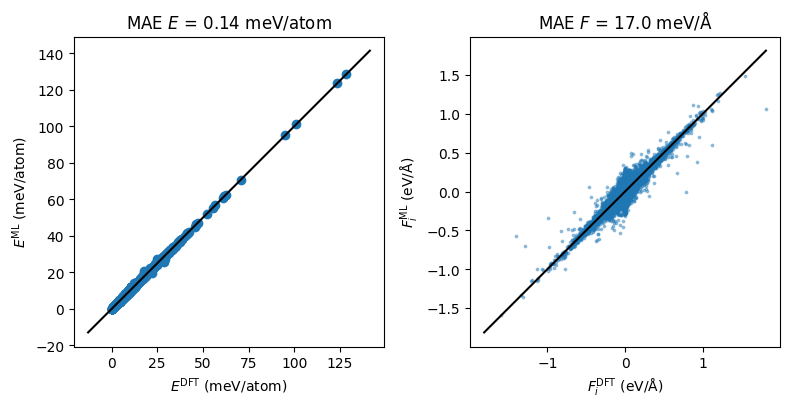

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from ase.io.trajectory import Trajectory

fig, ax = plt.subplots(1, 2)
fig.set_figheight(4)
fig.set_figwidth(8)

# Plot energies
x = np.load("predictions/e_dft.npy")
y = np.load("predictions/e_ml.npy")
print("MBTR energy error:", np.mean(np.abs(x - y)))

ax[0].scatter(x, y)
mi = min(np.min(x), np.min(y))
ma = max(np.max(x), np.max(y))
d = ma - mi
mi -= 0.1 * d
ma += 0.1 * d
ax[0].plot([mi, ma], [mi, ma], "-k")
ax[0].set_xlabel("$E^{\mathrm{DFT}}$ (meV/atom)")
ax[0].set_ylabel("$E^{\mathrm{ML}}$ (meV/atom)")
ax[0].set_title(f"MAE $E$ = {np.mean(np.abs(x-y)):.2f} meV/atom")
ax[0].set_aspect("equal")

# Plot forces
x = np.load("predictions/f_dft.npy").flatten()
y = np.load("predictions/f_ml.npy").flatten()
print("MBTR force error:", np.mean(np.abs(x - y)))

ax[1].scatter(x, y, s=3, alpha=0.4)
ma = max(np.max(np.abs(x)), np.max(y))
ax[1].plot([-ma, ma], [-ma, ma], "-k")
ax[1].set_xlabel("$F_i^{\mathrm{DFT}}$ (eV/Å)")
ax[1].set_ylabel("$F_i^{\mathrm{ML}}$ (eV/Å)")
ax[1].set_title(f"MAE $F$ = {np.mean(np.abs(x-y))*1000:.1f} meV/Å")
ax[1].set_aspect("equal")

plt.tight_layout()

### Structure optimization
Since the ML model can predict energy derivatives, it can be combined with an energy minimization algorithm to do structure optimization of perovskite structures.

First we define an Atomic Simulation Environment ([ASE](https://wiki.fysik.dtu.dk/ase/)) calculator that uses the ML model to predict energies and forces:

In [16]:
import numpy as np
from ase.calculators.calculator import Calculator

class ML_Calculator(Calculator):

    implemented_properties = ["energy", "forces"]

    def __init__(self, model, force_multiplier=1.0):
        self.model = model
        self.force_multiplier = force_multiplier
        super().__init__()

    def calculate(self, atoms, properties, system_changes):
        super().calculate(atoms, properties, system_changes)

        prop = ["y", "atomic_derivatives"]
        pred = self.model.predict_from_structure([atoms], properties=prop)

        e = pred["y"]
        self.results["energy"] = e

        f = -pred["atomic_derivatives"].reshape(-1, 3)
        f *= self.force_multiplier
        self.results["forces"] = f

We use the ASE calculator to minimize the energy of an atomic structure with BFGS algorithm.

In [17]:
import copy
from ase.optimize import BFGS

def relax_structure(
    structure,
    model,
    trajectory_file,
    force_limit=5e-3,
    force_multiplier=16,
    bfgs_maxstep=0.1,
    steps=1000000,
):
    s = copy.deepcopy(structure)
    calc = ML_Calculator(model, force_multiplier=force_multiplier)
    s.set_calculator(calc)

    dyn = BFGS(s, logfile=None, maxstep=bfgs_maxstep, trajectory=trajectory_file)
    dyn.run(fmax=force_limit * force_multiplier, steps=steps)

    return s, calc

To test the ML structure optimization scheme, we use it to relax 25 Pnma structures in the test set:

In [18]:
import pickle
import os

model = pickle.load(open("model.bin", "rb"))
d = merged_uniform_data()

te_initial_s_mask = (
    (d["train"] == False)
    & (d["relaxation_iteration"] == 0)
    & (d["lattice_type"] == "pnma")
)
structures = d.loc[te_initial_s_mask, "structure"].values
relaxation_number = d.loc[te_initial_s_mask, "relaxation_number"].values

if not os.path.exists("predictions/ml_relaxations"):
    os.makedirs("predictions/ml_relaxations")

for i, (s, n) in enumerate(zip(structures, relaxation_number)):
    print(f"Relaxing structure {i+1}/{len(structures)}")
    s_relax = relax_structure(s, model, f"predictions/ml_relaxations/pnma_{int(n)}.traj")

Relaxing structure 1/25
Relaxing structure 2/25
Relaxing structure 3/25
Relaxing structure 4/25
Relaxing structure 5/25
Relaxing structure 6/25
Relaxing structure 7/25
Relaxing structure 8/25
Relaxing structure 9/25
Relaxing structure 10/25
Relaxing structure 11/25
Relaxing structure 12/25
Relaxing structure 13/25
Relaxing structure 14/25
Relaxing structure 15/25
Relaxing structure 16/25
Relaxing structure 17/25
Relaxing structure 18/25
Relaxing structure 19/25
Relaxing structure 20/25
Relaxing structure 21/25
Relaxing structure 22/25
Relaxing structure 23/25
Relaxing structure 24/25
Relaxing structure 25/25


Finally, we compare the relaxation results to DFT relaxations of the same structure. First, we plot the energy of one perovskite structure optimized with both DFT and the ML model. Then, we compare the ML and DFT optimized energies of all 25 perovskite structures.

MBTR relaxation error single (meV/atom): 0.41971029713749886
MBTR relaxation error MAE: 0.2648301627486944
MBTR relaxation error max: 0.6967595545575023


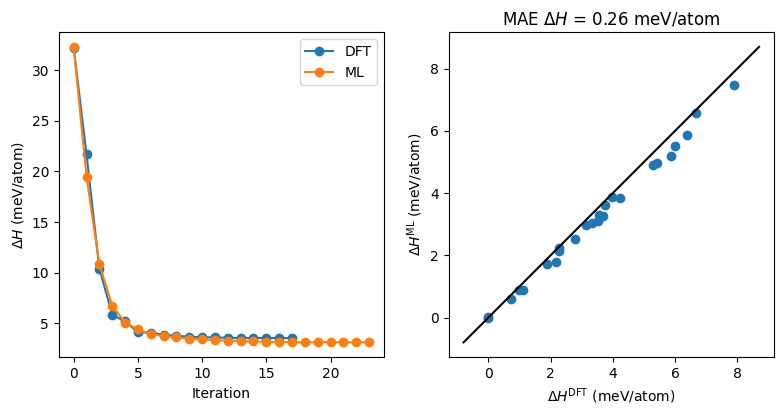

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from ase.io.trajectory import Trajectory

fig, ax = plt.subplots(1, 2)
fig.set_figheight(4)
fig.set_figwidth(8)

def plot_transform(e_tot, structures):
    return 1000 / 40 * EnthalpyOfMixingTransformation().transform(e_tot, structures)

d = merged_uniform_data()


# Plot one trajectory
phase = "pnma"
relax_n = 3018

dft_relax_mask = (d["lattice_type"] == phase) & (d["relaxation_number"] == relax_n)
e_dft = d.loc[dft_relax_mask, "total_energy"].values
s_dft = d.loc[dft_relax_mask, "structure"].values

s_ml = Trajectory(f"predictions/ml_relaxations/{phase}_{int(relax_n)}.traj")
e_ml = []
for s in s_ml:
    e_ml.append(s.get_potential_energy()[0])

print("MBTR relaxation error single (meV/atom):", (e_dft[-1] - e_ml[-1]) / 40 * 1000)

e_dft_plot = plot_transform(e_dft, s_dft)
e_ml_plot = plot_transform(e_ml, s_ml)
ax[0].plot(e_dft_plot, "-o", label="DFT")
ax[0].plot(e_ml_plot, "-o", label="ML")

ax[0].set_xlabel("Iteration")
ax[0].set_ylabel("$\Delta H$ (meV/atom)")
ax[0].legend()

xlim = ax[0].get_xlim()
ylim = ax[0].get_ylim()
ax[0].set_aspect((xlim[1] - xlim[0]) / (ylim[1] - ylim[0]))


# Plot all relaxed energies
relaxed_mask = ((d["train"] == False) & (d["relaxed"] == True) & (d["lattice_type"] == "pnma"))
e_dft_relax = d.loc[relaxed_mask, "total_energy"].values
s_dft_relax = d.loc[relaxed_mask, "structure"].values

e_ml_relax = []
for p, n in zip(d.loc[relaxed_mask, "lattice_type"], d.loc[relaxed_mask, "relaxation_number"]):
    traj = Trajectory(f"predictions/ml_relaxations/{p}_{int(n)}.traj")
    e_ml_relax.append(traj[-1].get_potential_energy()[0])
e_ml_relax = np.array(e_ml_relax)

mae = np.mean(np.abs(e_dft_relax - e_ml_relax))
maximum = np.max(np.abs(e_dft_relax - e_ml_relax))
print("MBTR relaxation error MAE:", mae / 40 * 1000)
print("MBTR relaxation error max:", maximum / 40 * 1000)

x = plot_transform(e_dft_relax, s_dft_relax)
y = plot_transform(e_ml_relax, s_dft_relax)

mi = min(np.min(x), np.min(y))
ma = max(np.max(x), np.max(y))
r = ma - mi
mi -= 0.1 * r
ma += 0.1 * r

ax[1].scatter(x, y)
ax[1].plot([mi, ma], [mi, ma], "-k")
ax[1].set_xlabel("$\Delta H^{\mathrm{DFT}}$ (meV/atom)")
ax[1].set_ylabel("$\Delta H^{\mathrm{ML}}$ (meV/atom)")
ax[1].set_title(f"MAE $\Delta H$ = {mae/40*1000:.2f} meV/atom")
ax[1].set_aspect("equal")

plt.tight_layout()